In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN

%matplotlib widget

# Introduction to Unsupervised Learning

##### Version 0.2

***

By AA Miller (Northwestern/CIERA)  
07 September 2023

Using the [ten hundred most common words](https://xkcd.com/simplewriter/) in the English language$^\dagger$, I would describe unsupervised learning as

> learning information without class names

or 

> finding hidden breaks between groups

$^\dagger$ See [Up-goer five](https://xkcd.com/1133/).

If we expand our volabulary slightly, then unsupervised learning could be described as 

> the search for underlying structure within the data

or

> learning from data without rewards (reinforcement learning) or labels (supervised learning)

What follows is a broad overview of several of the common techniques that constitute unsupervised learning. 

We start with a familiar example.

(you may not realize this, but you have all constructed unsupervised machine learning models...)

Suppose Nature produces some family of sources that tend to be either big or small. Mathematically we might represent the distribution of these sources as

$$P \propto 0.35\mathcal{N}(30, 5^2) + 0.65\mathcal{N}(60,8^2)$$

where $\mathcal{N}$ represents the normal distribution. 

Using [`np.random`](https://numpy.org/doc/stable/reference/random/index.html) we can generate samples from this distribution:

In [2]:
def generate_samples(n_sources):
    rand_dist = np.random.rand(n_sources)
    size = np.empty_like(rand_dist)
    small = rand_dist <= 0.35
    size[small] = np.random.normal(30, 5, size=sum(small))
    size[~small] = np.random.normal(60,8,  size=sum(~small))
    return size

In practice, we observe nature and do not know the true probability density function (PDF) for the sources of interest.

This brings us to our first example of unsupervised learning:

## 1) Density Estimation



### A) Histograms

If we measure the size of 100 sources from the aforementioned subject of interest, we can estimate the PDF via a histogram.

In [3]:
np.random.seed(2016)
sizes = generate_samples(100)

def hist_plot(ax, fs=16):
    ax.hist(sizes, histtype='step',lw=3)
    ax.set_ylabel("N", fontsize=fs)
    ax.set_xlabel("size", fontsize=fs)
    ax.set_xlim(15,85)
    ax.tick_params(axis='both', labelsize=12)

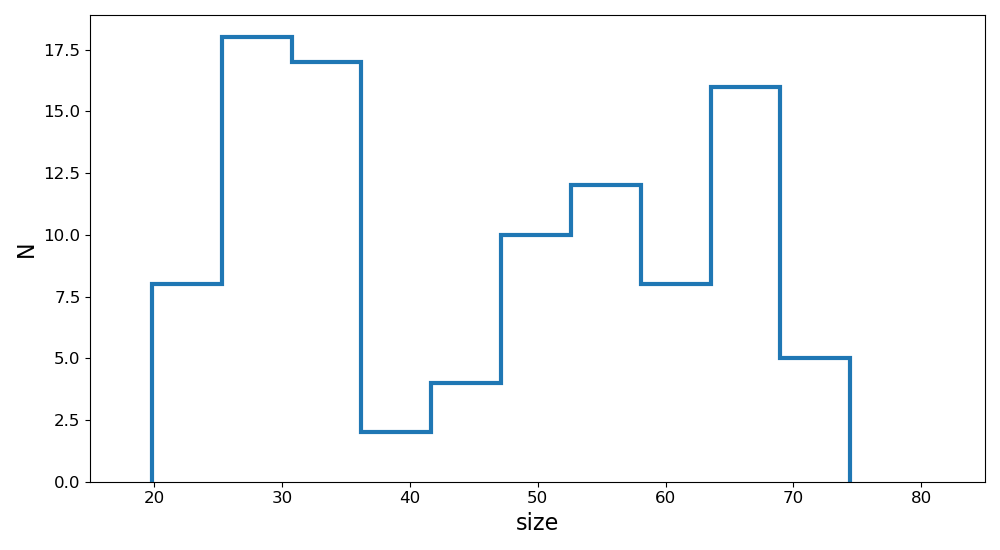

In [4]:
fig, ax = plt.subplots(figsize=(10,5.5))
hist_plot(ax)
fig.tight_layout()

I have previously discussed histograms, and their potential pitfalls, at length previously, so I will not subject you to that again. But I will quickly remind you that kernel density estimation (KDE) provides a nice alternative to histograms. 

### B) KDE

In [5]:
def kde_plot(ax, fs=15):
    xgrid = np.linspace(0,100,5000)
    kde = np.zeros_like(xgrid)
    for s in sizes:
        kern = 1/np.sqrt(2*np.pi*3**2)*np.exp(-(xgrid - s)**2/(2*3**2))
        kde += kern
        ax.plot(xgrid, kern, '0.5', lw=0.3, alpha=0.5)
    ax.plot(xgrid, kde, 'k', lw=4)
    ax.set_ylabel("N", fontsize=fs)
    ax.set_xlabel("size", fontsize=fs)
    ax.set_xlim(5,95)
    ax.tick_params(axis='both', labelsize=12)

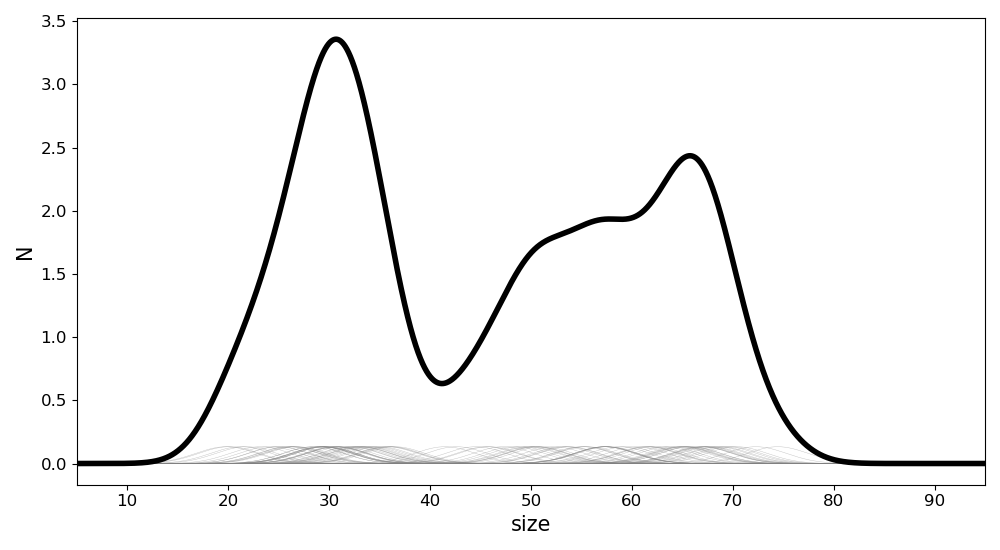

In [6]:
fig, ax = plt.subplots(figsize=(10,5.5))
kde_plot(ax)
fig.tight_layout()

A nice aspect of KDE is that it generalizes to multiple dimensions in a fairly straightforward fashion.

Be aware of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) for density estimation (and all unsupervised machine learning applications). 

In brief, high dimensional datasets are inherently sparse. As the number of dimensions $D$ increases, all samples become relatively equidistant meaning clusters or regions of high density are difficult to identify.

We can illustrate this by drawing 10 random points from a standard multivariate normal, and measure how the distance between the closest points increases with $D$.

In [7]:
n_samples = 10
for n_dim in [2, 3, 10, 100, 1000]:
    mean = np.zeros(n_dim)
    cov = np.identity(n_dim)
    samples = np.random.multivariate_normal(mean, cov, n_samples)
    min_sep = 1e8
    for sample in samples:
        sep = np.sqrt(np.sum((samples - sample)**2, axis=1))
        min_sep = np.min([min_sep, np.min(sep[np.where(sep > 0)])])
    print(f'For {n_dim} dimensions, min separation = {min_sep:.4f}')

For 2 dimensions, min separation = 0.2279
For 3 dimensions, min separation = 0.3680
For 10 dimensions, min separation = 2.6061
For 100 dimensions, min separation = 11.6929
For 1000 dimensions, min separation = 42.5673


Fortunately, unsupervised learning can help with the curse of dimensionality via... 

## 2) Dimensionality Reduction

Dimensionality reduction is not the focus of today's lecture, but I will mention two methods that are common in the astrophysical literature. I will not present full derivations.  

## A) Principal Component Analysis (PCA)

PCA is the linear combination of variables that provide the maximum variability within a data set. 

Using techniques from linear algebra (eigenvectors), PCA defines the direction of maximum variance (first principal component), then finds the direction of maximum variance that is orthogonal to the first component (second principal component), and so on.

<img style="display: block; margin-left: auto; margin-right: auto" src="images/pca-3d.png" width="450" align="middle">
<div align="right"> <font size="-3">(credit: <a href="url">https://learnopencv.com/principal-component-analysis/</a>) </font></div>



PCA has become less popular recently. It is scale dependent - if one feature varies from 0 to 1 and another varies from -500 to 500, the later will be determined to be more important. 

Furthermore, it is rarely the case that an orthogonal basis can truly describe all the variance present in a data set. Imagine a bunch of points on the surface of a sphere for example. 

(this will be covered in more detail in Bryan's talk that follows this one)

## B) t-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is magic!

The hand-waving explanation is that t-SNE finds a low-dimensional projection of high-dimensional data sets where small and large distances in the high-dimensional space are preserved in the low-dimensional projection. 

<img style="display: block; margin-left: auto; margin-right: auto" src="images/tSNE_scikit_learn.png" width="650" align="middle">
<div align="right"> <font size="-3">(credit: scikit-learn) </font></div>


I refer those interested to the original paper by [van der Maaten & Hinton](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

(and of course Bryan's talk that follows this one)

## 3) Clustering

When I think about unsupervised learning, clustering is always at the forefront of my mind. 

A cluster is a collection of objects that are all similar while also being dissimilar to other objects. 

Machine learning methods can be used to search for clusters within a multidimensional feature space. 

There are many algorithms that can be used for clustering. We will develop an intuition for how clustering works by examining a few of these methods in detail. 

## A) K-means

Every discussion of clustering starts with K-means, which is a simple method to identify clusters within a dataset.

In brief, the user specifies the number of clusters to search for $K$, and the algorithm proceeds to divide sources in the feature space accordingly. 

The pseudocode is:  

  1. choose the number of clusters, K
  2. choose K random sources for initial cluster centers
  3. assign each source to the nearest cluster (min distance between cluster center and source)
  4. update the position of the cluster center to be the mean position of all in-cluster sources
  5. repeat steps 3 and 4


Once a user-specified stopping criteria is reached, such as $N$ cluster updates or some small fractional change in the cluster centers, further updates do not occur. 

We can visually demonstrate how this works.

In [8]:
X, y = make_blobs([50,100,100], n_features=2, cluster_std=1, center_box=(-4,4), random_state=23)

def kmeans_init(ax, fs=15):
    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors='k')
    ax.scatter(X[0:3,0], X[0:3,1], 
           marker='X', s=500, c=[0,1,2], edgecolors='0.7')
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

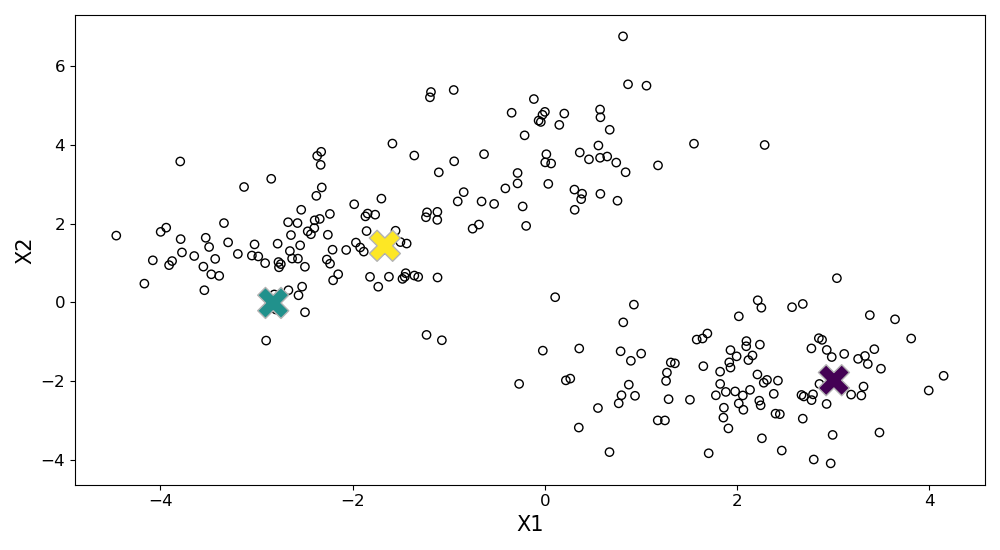

In [9]:
fig, ax = plt.subplots(figsize=(10,5.5))
kmeans_init(ax)
fig.tight_layout()

Now we assign every point to it's respective cluster:

In [10]:
def kmeans_assign(ax, X=X, fs=15):
    clf = KMeans(n_clusters=3, init = X[0:3], max_iter=1, n_init=1)
    clf.fit(X)
    
    cmap = plt.get_cmap("viridis")
    colors = cmap(clf.labels_/2)

    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors=colors)
    ax.scatter(X[0:3,0], X[0:3,1], 
           marker='X', s=500, c=[0,1,2], edgecolors='0.7')
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

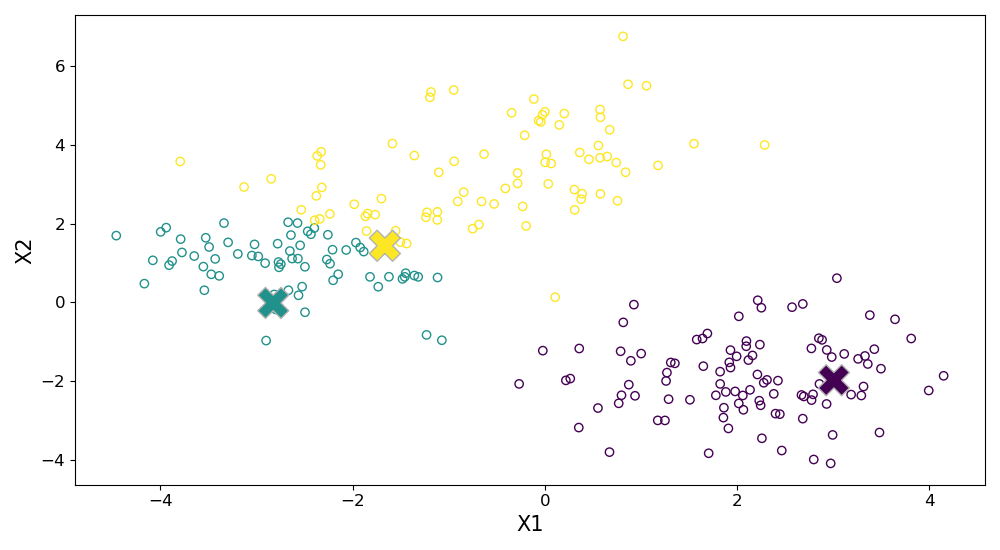

In [11]:
fig, ax = plt.subplots(figsize=(10,5.5))
kmeans_assign(ax)
fig.tight_layout()

And update the cluster centers: 

In [12]:
clf = KMeans(n_clusters=3, init = X[0:3], max_iter=1, n_init=1)
clf.fit(X)

cmap = plt.get_cmap("viridis")
colors = cmap(clf.labels_/2)

center1 = clf.cluster_centers_

def kmeans1(ax, X=X, fs=15):

    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors=colors)
    ax.scatter(X[0:3,0], X[0:3,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.6)
    ax.scatter(center1[:,0], center1[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7')
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

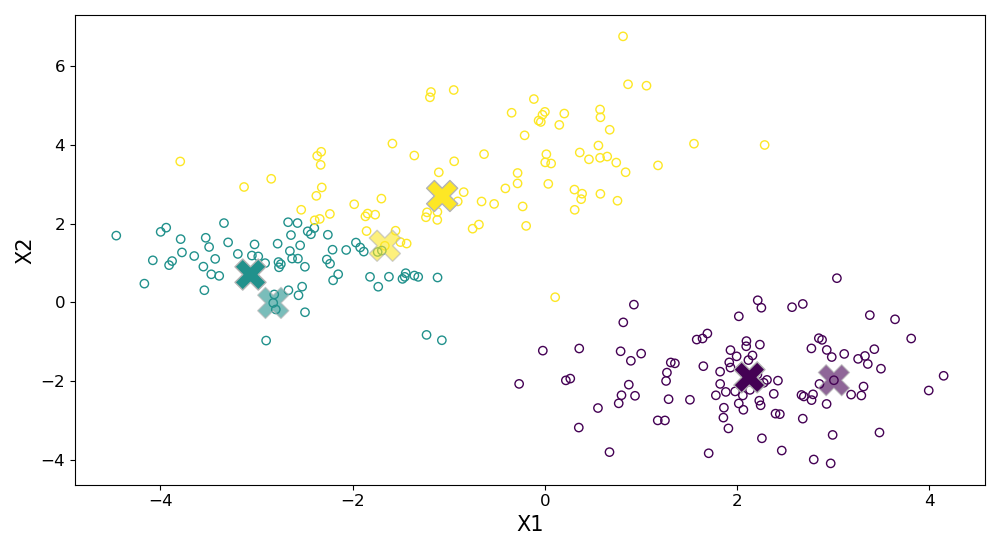

In [13]:
fig, ax = plt.subplots(figsize=(10,5.5))
kmeans1(ax)
fig.tight_layout()

Now repeat the assign and update steps: 

In [14]:
clf = KMeans(n_clusters=3, init = X[0:3], max_iter=2, n_init=1)
clf.fit(X)

cmap = plt.get_cmap("viridis")
colors = cmap(clf.labels_/2)
center2 = clf.cluster_centers_

def kmeans2(ax, fs=15):

    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors=colors)
    ax.scatter(X[0:3,0], X[0:3,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.5)
    ax.scatter(center1[:,0], center1[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.75)
    ax.scatter(center2[:,0], center2[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7')
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

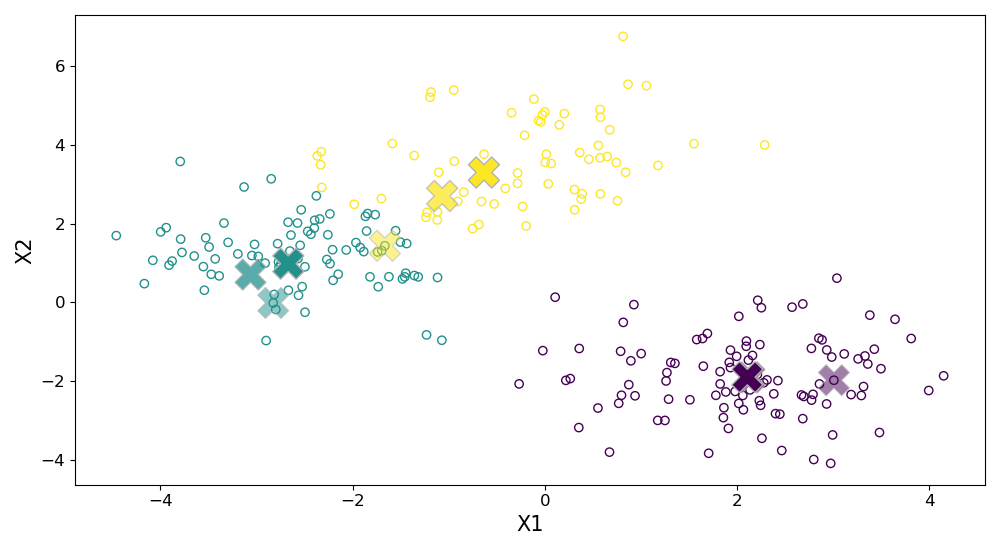

In [15]:
fig, ax = plt.subplots(figsize=(10,5.5))
kmeans2(ax)
fig.tight_layout()

And again:

In [16]:
clf = KMeans(n_clusters=3, init = X[0:3], max_iter=3, n_init=1)
clf.fit(X)

cmap = plt.get_cmap("viridis")
colors = cmap(clf.labels_/2)

center3 = clf.cluster_centers_

def kmeans3(ax, fs=15):
    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors=colors)
    ax.scatter(X[0:3,0], X[0:3,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.25)
    ax.scatter(center1[:,0], center1[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.5)
    ax.scatter(center2[:,0], center2[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.75)
    ax.scatter(center3[:,0], center3[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7')
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

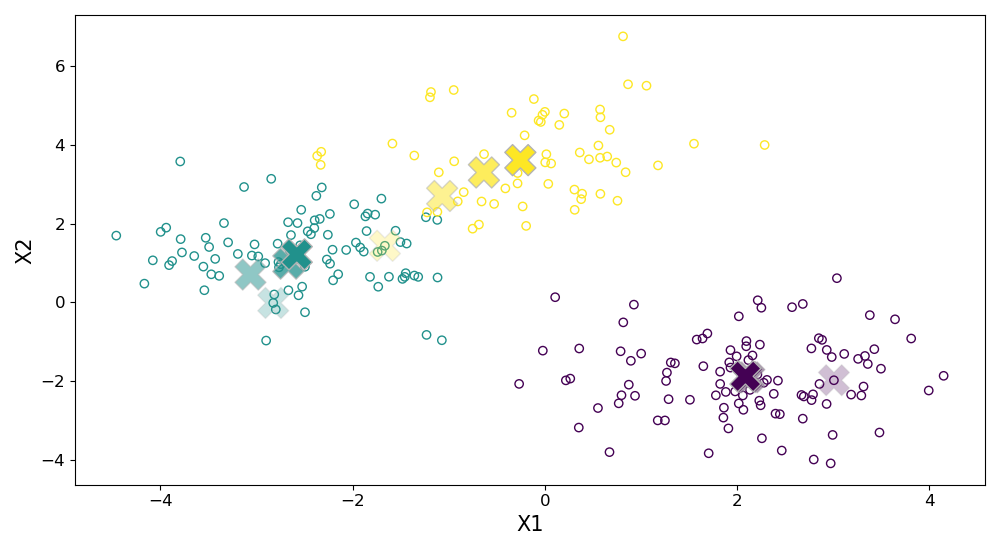

In [17]:
fig, ax = plt.subplots(figsize=(10,5.5))
kmeans3(ax)
fig.tight_layout()

And fast forward to 100 iterations: 

In [18]:
clf = KMeans(n_clusters=3, init = X[0:3], max_iter=100, n_init=1)
clf.fit(X)

cmap = plt.get_cmap("viridis")
colors = cmap(clf.labels_/2)

center4 = clf.cluster_centers_

def kmeans100(ax, fs=15):
    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors=colors)
    ax.scatter(X[0:3,0], X[0:3,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.2)
    ax.scatter(center1[:,0], center1[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.4)
    ax.scatter(center2[:,0], center2[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.6)
    ax.scatter(center3[:,0], center3[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7', alpha=0.8)
    ax.scatter(center4[:,0], center4[:,1], 
               marker='X', s=500, c=[0,1,2], edgecolors='0.7')
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

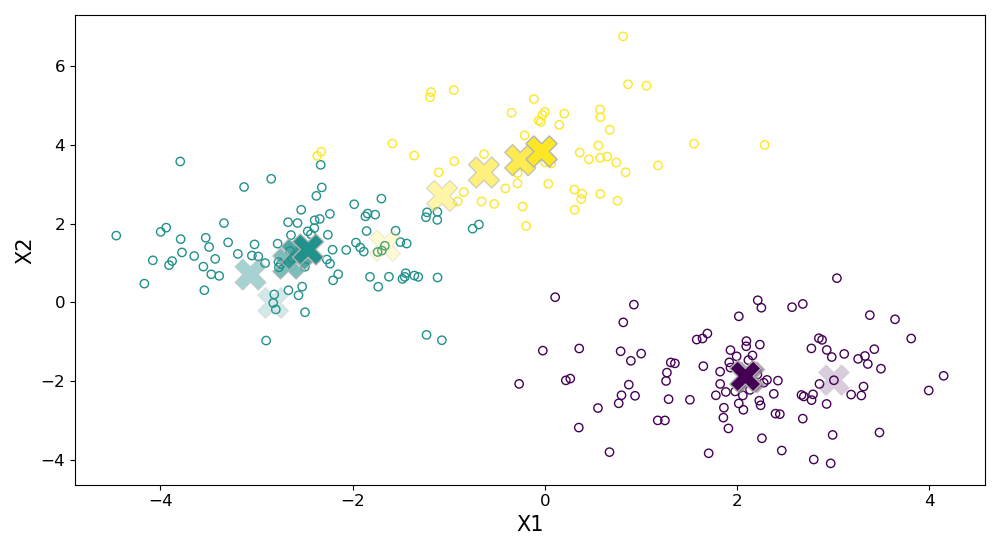

In [19]:
fig, ax = plt.subplots(figsize=(10,5.5))
kmeans100(ax)
fig.tight_layout()

For this (extremely) simple example we can see that the clusters have converged. 

Under the hood, there are some user-defined parameters (e.g., distance metric – we used Euclidean), but one choice stands above all else...

How in the world do we choose $K$? 

For the previous example, we created the data and therefore knew $K = 3$ was reasonable. When clustering new data, however, $K$ is truly unknown. By definition the algorithm will always find $K$ clusters, whether or not there are $K$ clusters present. 

Many clustering methods require the user to specify the number of clusters, prior to the application of the algorithm. There is also no natural metric for calculating if the specified number of clusters is correct. 

Other methods do not require an a priori number of clusters:

## B) DBSCAN

The [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) algorithm searches for clusters using a user-specified radius $\epsilon$.

For each source the number of other sources within a distance $\epsilon$ is counted. 

Sources with N >= `minPts` neighbors are considered core points (`minPts` is user-specified)  
Sources with N < `minPts` neighbors, but at least one core neighbor, are "reachable" and part of the cluster  
All sources that cannot be reached by a core point are considered "outliers"

<img style="display: block; margin-left: auto; margin-right: auto" src="images/DBSCAN.png" width="750" align="middle">
<div align="right"> <font size="-3">(credit: wikiCommons) </font></div>


We can demonstrate this with the simulated data used in the KMeans example: 

In [20]:
clf = DBSCAN(eps=1, min_samples=10)
clf.fit(X)

cmap = plt.get_cmap("viridis")
colors = cmap((clf.labels_+1)/np.max(clf.labels_+1))

def dbscan(ax, fs=15):
    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors=colors)
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

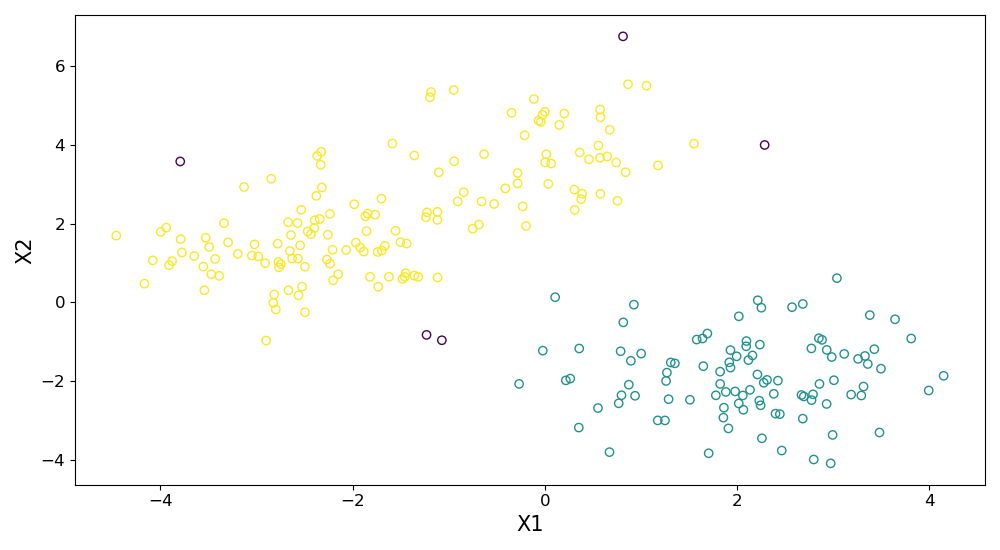

In [21]:
fig, ax = plt.subplots(figsize=(10,5.5))
dbscan(ax)
fig.tight_layout()

In this case we can see that two clusters are identified, along with 5 outliers. 

Again - there are no metrics to know whether or not this is "correct" (or "better" than what we got from KMeans).

DBSCAN introduces the last component of unsupervised learning that we will discuss today.

## 4) Anomaly Detection

A topic of great interest for the Rubin Observatory is anomaly detection. It is easy to understand why:  

$~~~~$what if there are undiscovered galaxy subtypes?  

$~~~~$what if there is a Type III supernova?  

$~~~~$what if we don't understand the systematics in the Rubin observing system?

All of these questions might be answered via anomaly/outlier detection. 

How do we identify anomalies? Rather than discuss specific algorithms, I will review some of the types of outliers that we might be worthy of extra attention. 

(speaking of algorithms, we just saw one - `DBSCAN`  
... or... you could use a KDE, and identify any sources/new observations with really low probability as outliers

also, also – we have an entire lecture on autoencoders, which are a very promissing method for finding unusual behavior in the Rubin Observatory data)

**Global outliers** live far outside the entirety of the remaining data set:

In [22]:
np.random.seed(23)
x = np.random.uniform(0,20,100)
y = 3 + x**2 + np.random.normal(0,15, size=len(x))
y[55] += 250

def outlier(ax, fs=15):
    ax.plot(x,y, 'o', mfc='None')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.annotate("outlier",
                xy=(x[55]+.25, y[55]), xycoords='data',
                xytext=(7.5, 325), textcoords='data',
                size=12, va="center", ha="center",
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2"))
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)


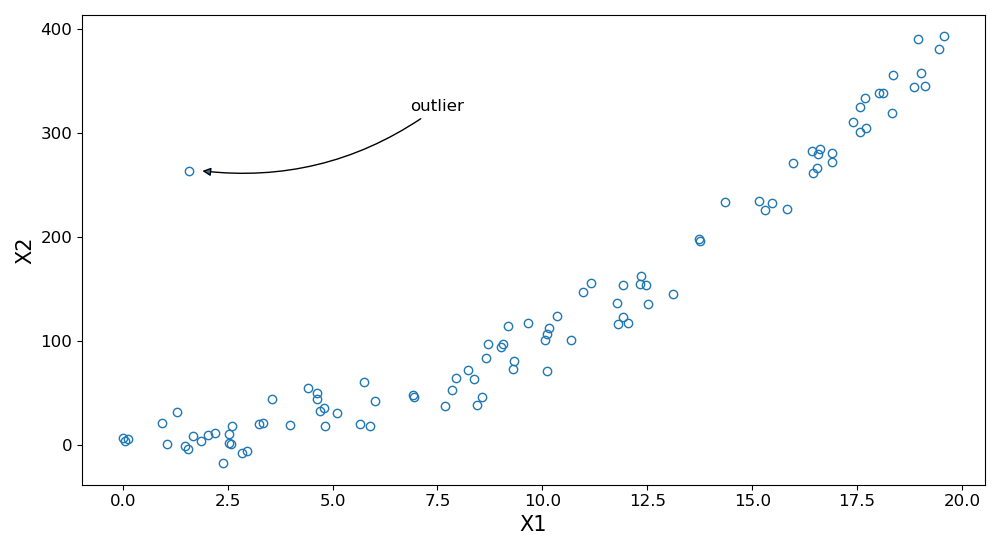

In [23]:
fig, ax = plt.subplots(figsize=(10,5.5))
outlier(ax)
fig.tight_layout()

**Contextual outliers** are observations that standout relative to their context:


<img style="display: block; margin-left: auto; margin-right: auto" src="images/flu-season-coronavirus-pandemic.png" width="750" align="middle">
<div align="right"> <font size="-3">(credit: NY Times) </font></div>


**Local outliers** are unusual relative to a particular grouping of the data.

In [24]:
X, y = make_blobs([40,70], n_features=2, cluster_std=1, center_box=(-7,7), random_state=7)

def local_outlier(ax, fs=15):
    ax.scatter(X[:,0], X[:,1], facecolor="None", edgecolors='k')
    ax.annotate("local outlier",
                xy=(-2.85, 5.28), xycoords='data',
                xytext=(-0.6, 5.9), textcoords='data',
                size=12, va="center", ha="center",
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0.2"))
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

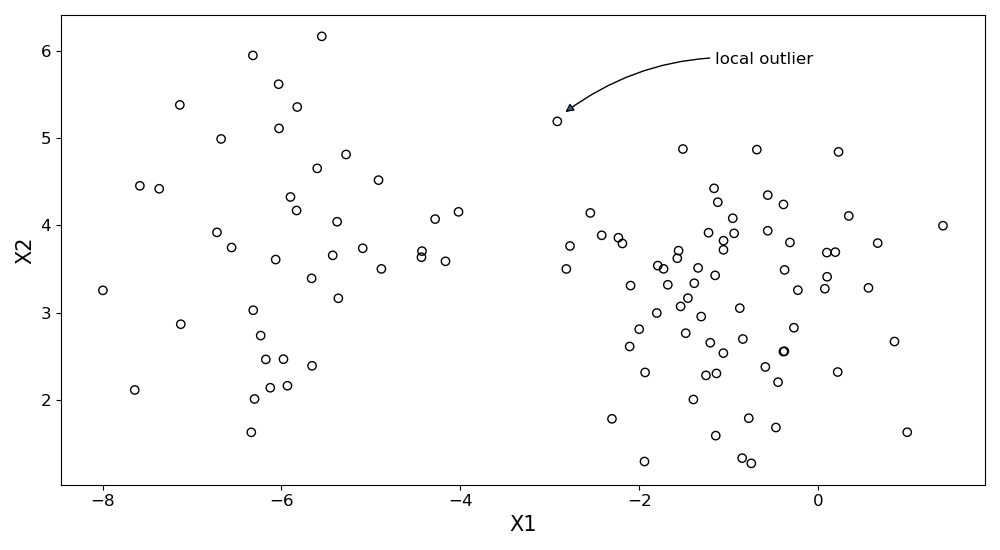

In [25]:
fig, ax = plt.subplots(figsize=(10,5.5))
local_outlier(ax)
fig.tight_layout()

**Label outliers** are unusual relative to their their assigned class.

In [26]:
X, y = make_blobs([40,70], n_features=2, cluster_std=1, center_box=(-7,7), random_state=7)
y[23] -= 1
colors = cmap(y-0.3)

def label_outlier(ax, fs=15):
    ax.scatter(X[:,0], X[:,1], s=50, linewidths=2.5,
               facecolor="None", edgecolors=colors)
    # ax.text(1.1, 4.2, 'label outlier', ha='center')
    ax.annotate("label outlier",
                xy=(1.4, 4.1), xycoords='data',
                xytext=(-1.5, 5.9), textcoords='data',
                size=12, va="center", ha="center",
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2"))
    
    ax.set_xlabel('X1', fontsize=fs)
    ax.set_ylabel('X2', fontsize=fs)
    ax.tick_params(axis='both', labelsize=12)

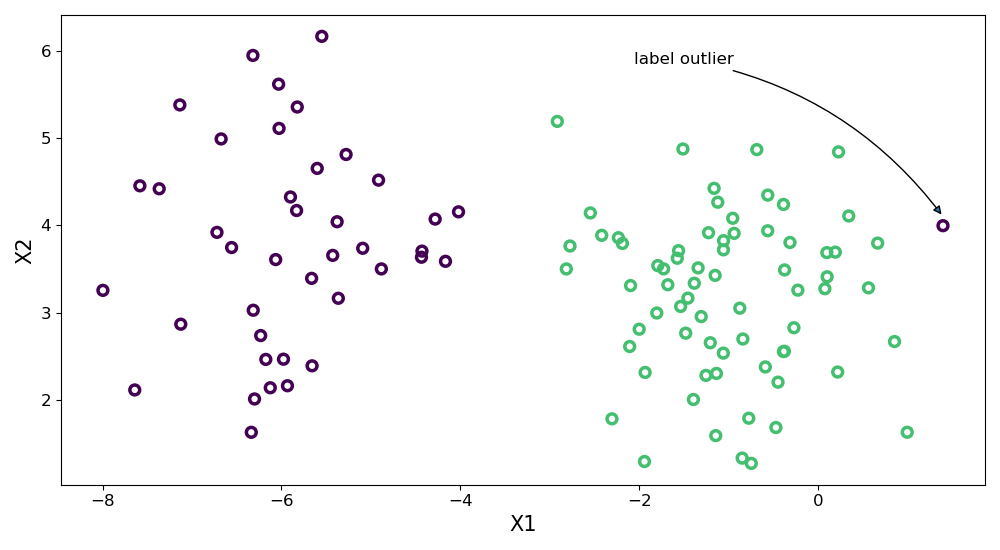

In [27]:
fig, ax = plt.subplots(figsize=(10,5.5))
label_outlier(ax)
fig.tight_layout()

The detection/identification of anomalies can lead to exciting new astronomical discoveries (e.g., Quasars, Boyajian's star, etc). 

The *systematic* identification of anomalies is difficult, and in most astronomical data sets the population of outliers that are present is dominated by telescope artifacts/systematics. 

## Conclusions

While I have just presented an entire lecture on the subject, I must confess – I am not a huge fan of unsupervised learning. 

The main reason I feel this way is that there is no method to verify the accuracy of newly identified clusters.  
$~~~~$Is $K$ actually 7, or should it have been 6?  
$~~~~$If `minPts` doubles, does the number of clusters increase? 

To answer these questions requires the collection of significant follow-up data. The follow-up is the hard part, and now that has been delayed by trying to identify clusters in the first place. 

Furthermore, I am not aware of any truly groundbreaking problems that were intractable and then miraculously solved by unsupervised learning. 

Unsupervised learning is very useful in certain contexts:  

$~~~~$Exploratory analysis/visualization (density estimation, dimensionality reduction)

$~~~~$Semi-supervised learning ($N_\mathrm{unlabeled} \gg N_\mathrm{labeled}$)

$~~~~$"Live" supervised models (e.g., find newly emerging classes)